# Housing Example

- required package to download data: !pip install pandas-datareader
- blog post 1: https://towardsdatascience.com/introducing-scalecast-a-forecasting-library-pt-1-33b556d9b019
- blog post 2: https://towardsdatascience.com/forecast-on-3-levels-introducing-scalecast-pt-3-eb725e0be6c9

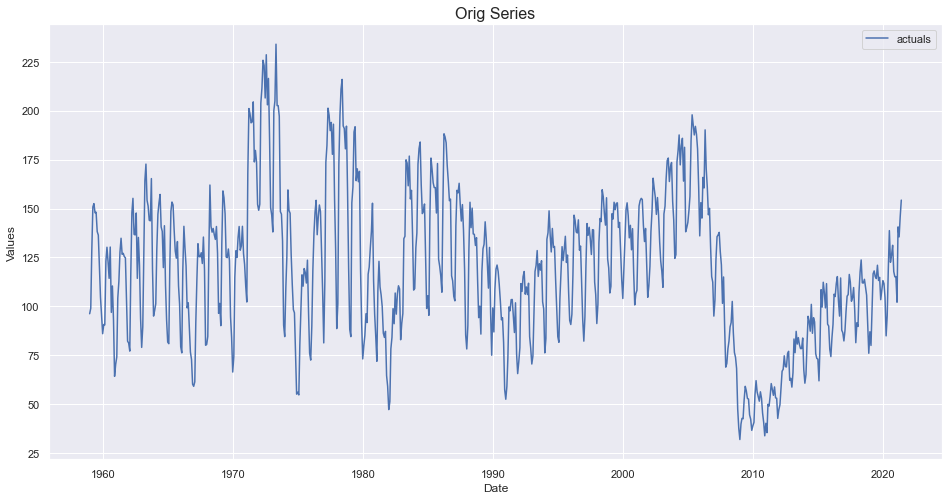

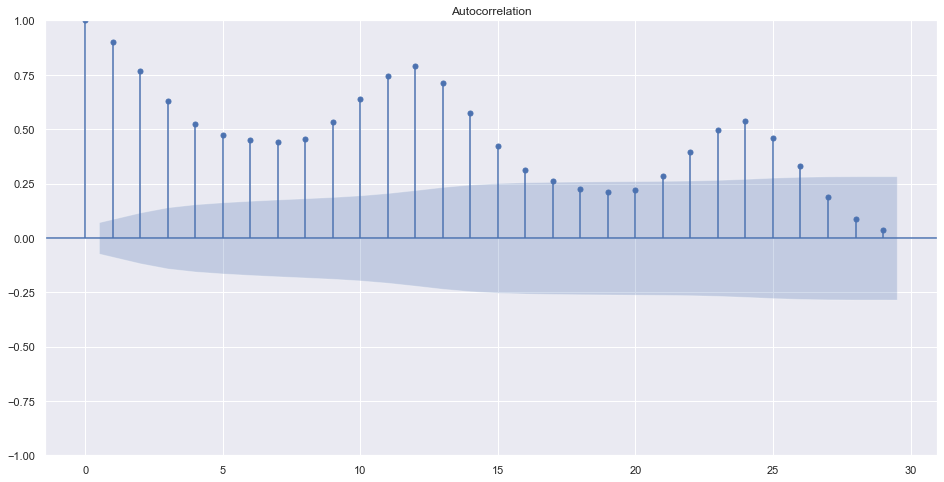

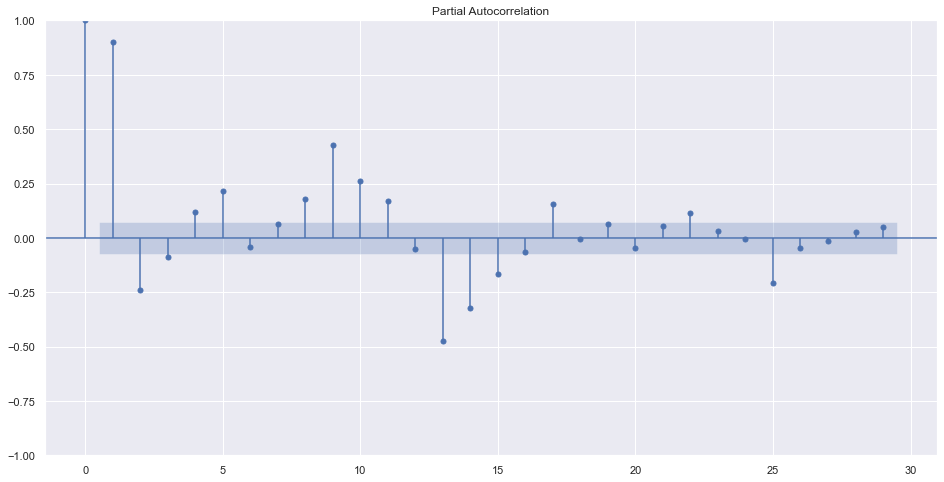

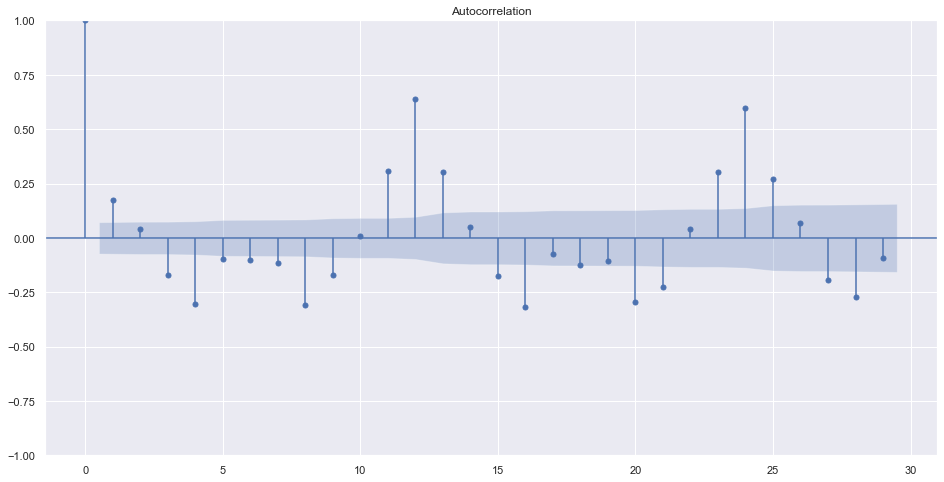

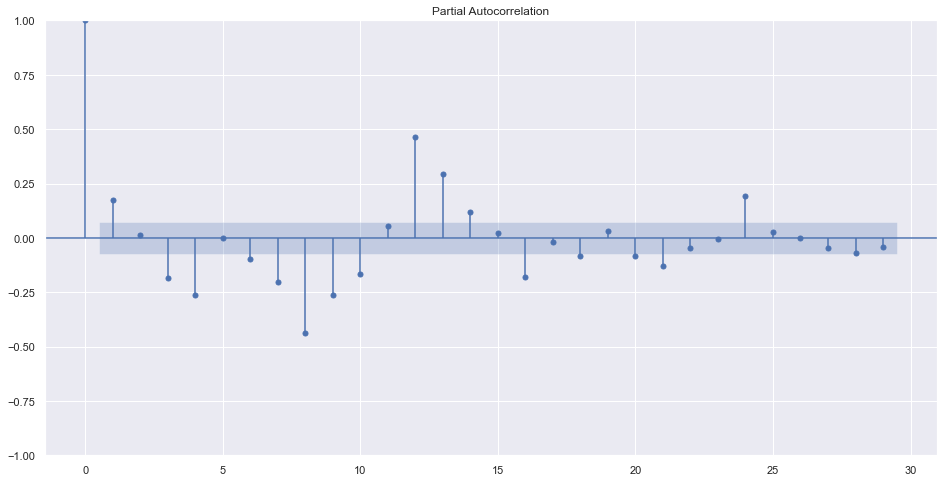

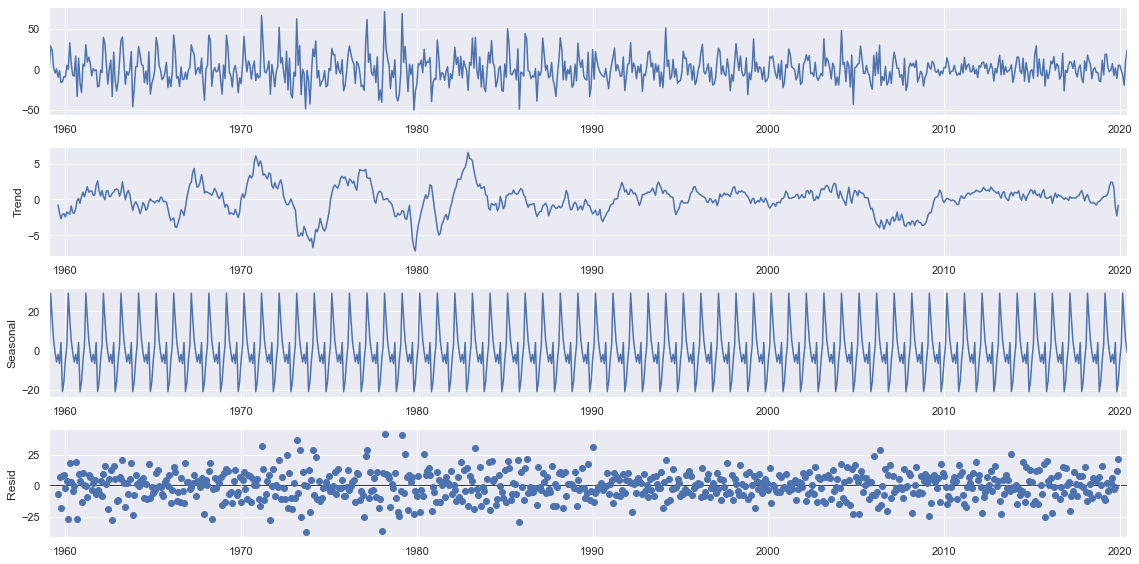

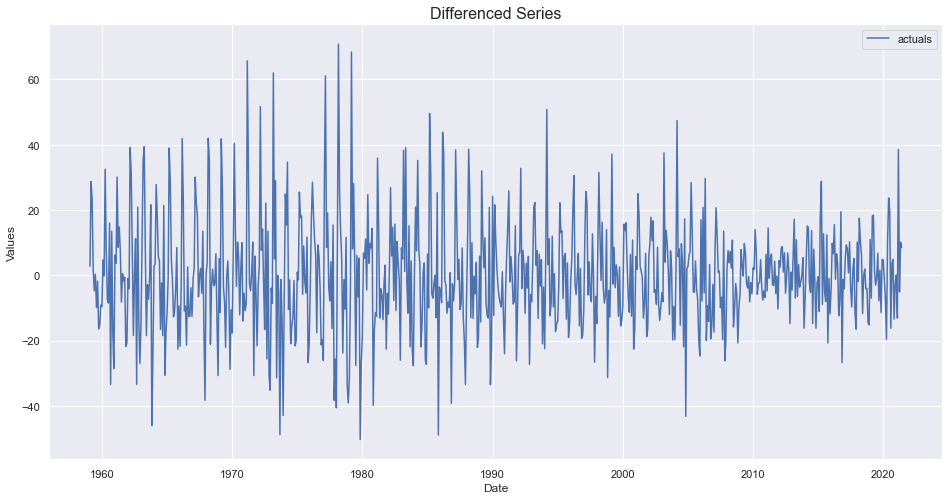

series appears to be stationary
silverkite TestSetRMSE: 13.83945973859246
silverkite TestSetR2: 0.1282865206832411
silverkite TestSetMAPE: 6.805997555488756
silverkite HyperParams: {'changepoints': 0}
silverkite Xvars: None
knn TestSetRMSE: 13.84369388626701
knn TestSetR2: 0.12775304202272453
knn TestSetMAPE: 0.946259710045044
knn HyperParams: {'n_neighbors': 20, 'weights': 'uniform'}
knn Xvars: ['AR1', 'AR2', 'AR3', 'AR4', 'AR12', 'AR24', 'monthsin', 'monthcos', 'year', 'COVID19', 't', 't_COVID19']
svr TestSetRMSE: 13.957081169362521
svr TestSetR2: 0.11340618595610841
svr TestSetMAPE: 3.2708541917165124
svr HyperParams: {'kernel': 'linear', 'C': 3.0, 'epsilon': 0.5}
svr Xvars: ['AR1', 'AR2', 'AR3', 'AR4', 'AR12', 'AR24', 'monthsin', 'monthcos', 'year', 'COVID19', 't', 't_COVID19']
elasticnet TestSetRMSE: 14.026425925241938
elasticnet TestSetR2: 0.10457434469882299
elasticnet TestSetMAPE: 6.663780491287947
elasticnet HyperParams: {'alpha': 1.3, 'l1_ratio': 1.0}
elasticnet Xvars: ['AR1'

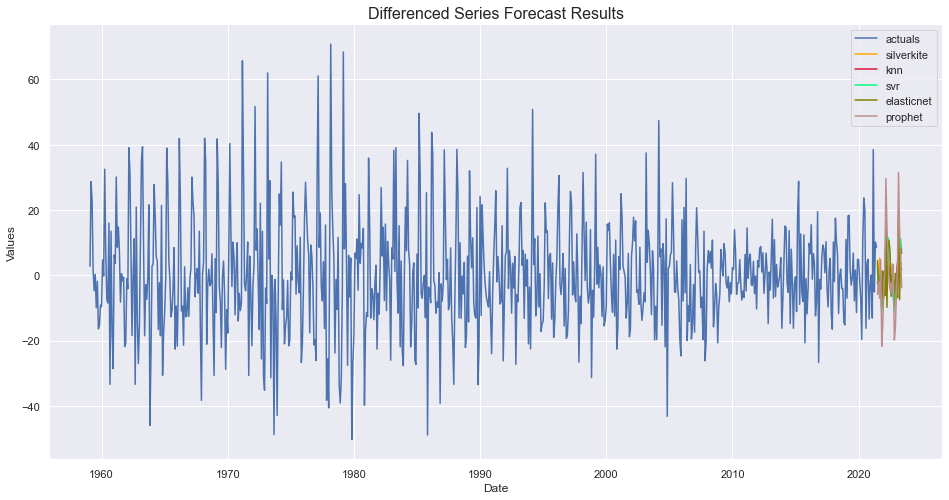

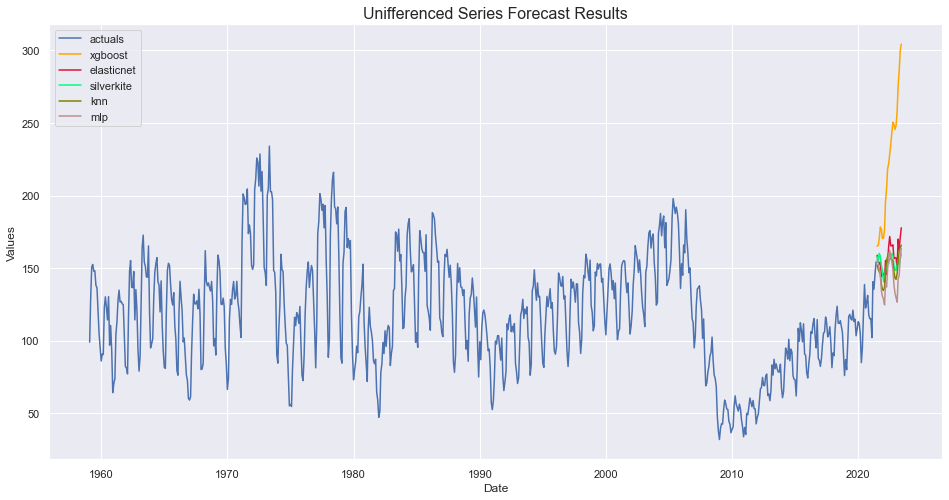

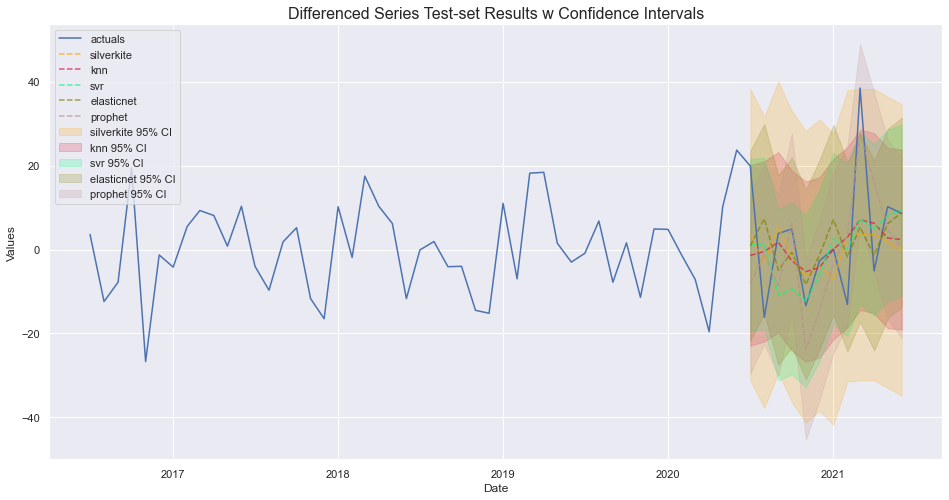

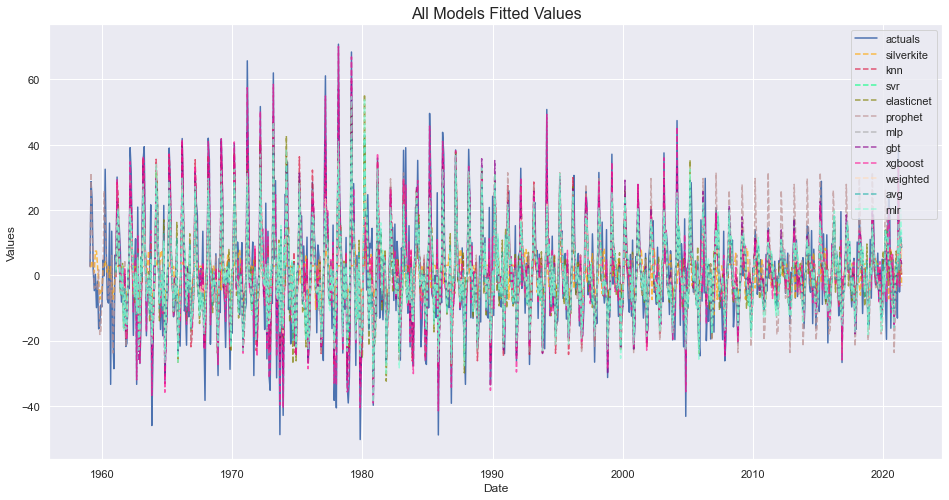

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster

sns.set(rc={'figure.figsize':(16,8)})

models = ('mlr','knn','svr','xgboost','gbt','elasticnet','mlp','prophet','silverkite')
df = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index) # to initialize, specify y and current_dates (must be arrays of the same length)
f.set_test_length(12) # specify a test length for your models - do this before eda
f.plot()
plt.title('Orig Series',size=16)
plt.show()

# eda
f.plot_acf(train_only=True)
f.plot_pacf(train_only=True)
plt.show()

# eda on differenced data
f.plot_acf(diffy=True,train_only=True)
f.plot_pacf(diffy=True,train_only=True)
plt.show()
f.seasonal_decompose(diffy=True,train_only=True).plot()
plt.show()

# model preprocessing
f.generate_future_dates(24) # this will create future dates that are on the same interval as the current dates and it will also set the forecast length
f.add_ar_terms(4) # add AR terms before differencing
f.add_AR_terms((2,12)) # seasonal AR terms
f.diff() # differences the y term and all ar terms to make a series stationary (also supports 2-level integration)
f.plot()
plt.title('Differenced Series',size=16)
plt.show()
f.adf_test(quiet=False) # it is now stationary
f.add_seasonal_regressors('month',raw=False,sincos=True) # uses pandas attributes: raw=True creates integers (default), sincos=True creates wave functions (not default), dummy=True creates dummy vars (not default)
f.add_seasonal_regressors('year')
f.add_covid19_regressor() # dates are flexible, default is from when disney world closed to when US CDC lifted mask recommendations
f.add_time_trend()
f.add_combo_regressors('t','COVID19') # multiplies regressors together
f.set_validation_length(6) # length, different than test_length, to tune the hyperparameters 
f.tune_test_forecast(models,feature_importance=True,summary_stats=True) # by default, tuning is not dynamic but testing is

# combine models and run manually specified models of other varieties
f.set_estimator('combo')
f.manual_forecast(how='simple',models='top_3',determine_best_by='ValidationMetricValue',call_me='avg') # simple average of top_3 models based on performance in validation
f.manual_forecast(how='weighted',models=models,determine_best_by='ValidationMetricValue',call_me='weighted') # weighted average of all models based on metric specified in determine_best_by (default is the validation metric)

# plot results
matplotlib.use('QT5Agg')
f.plot(models='top_5',order_by='TestSetRMSE',print_attr=['TestSetRMSE','TestSetR2','TestSetMAPE','HyperParams','Xvars','models']) # plots the forecast differences or levels based on the level the forecast was performed on
plt.title('Differenced Series Forecast Results',size=16)
plt.show()
f.plot(models='top_5',order_by='LevelTestSetMAPE',level=True,print_attr=['LevelTestSetRMSE','LevelTestSetR2','LevelTestSetMAPE']) # plot the level forecast
plt.title('Unifferenced Series Forecast Results',size=16)
plt.show()
f.plot_test_set(models='top_5',order_by='TestSetR2',include_train=60,ci=True) # see test-set performance visually of top 5 best models by r2 (last 60 obs only)
plt.title('Differenced Series Test-set Results w Confidence Intervals',size=16)
plt.show()
f.plot_fitted(order_by='TestSetR2') # plot fitted values of all models ordered by r2
plt.title('All Models Fitted Values',size=16)
plt.show()

# export key results
f.export(to_excel=True,determine_best_by='LevelTestSetMAPE',excel_name='housing_results.xlsx') # export interesting model metrics and forecasts (both level and non-level)
f.all_feature_info_to_excel(excel_name='housing_feature_info.xlsx')

# Housing Different Levels Example

weighted_diff LevelTestSetRMSE: 10.932673113409109
weighted_diff LevelTestSetR2: 0.4207760663045943
weighted_diff LevelTestSetMAPE: 0.07037192623920496
weighted_diff HyperParams: {'how': 'weighted', 'models': ('knn', 'svr', 'lightgbm', 'mlp', 'elasticnet'), 'determine_best_by': 'ValidationMetricValue'}
weighted_diff Xvars: None
weighted_diff models: ['elasticnet', 'mlp', 'svr', 'knn', 'lightgbm']
elasticnet LevelTestSetRMSE: 12.832874373112459
elasticnet LevelTestSetR2: 0.20192876366986756
elasticnet LevelTestSetMAPE: 0.08414943396922821
elasticnet HyperParams: {'alpha': 1.3, 'l1_ratio': 1.0}
elasticnet Xvars: ['AR1', 'AR2', 'AR3', 'AR4', 'AR12', 'AR24', 'monthsin', 'monthcos', 'year', 'COVID19', 't', 't_COVID19']
avg_diff LevelTestSetRMSE: 13.623331731464042
avg_diff LevelTestSetR2: 0.10058435690584389
avg_diff LevelTestSetMAPE: 0.08906940354174113
avg_diff HyperParams: {'how': 'simple', 'models': ('knn', 'svr', 'lightgbm', 'mlp', 'elasticnet'), 'determine_best_by': 'ValidationMetricV

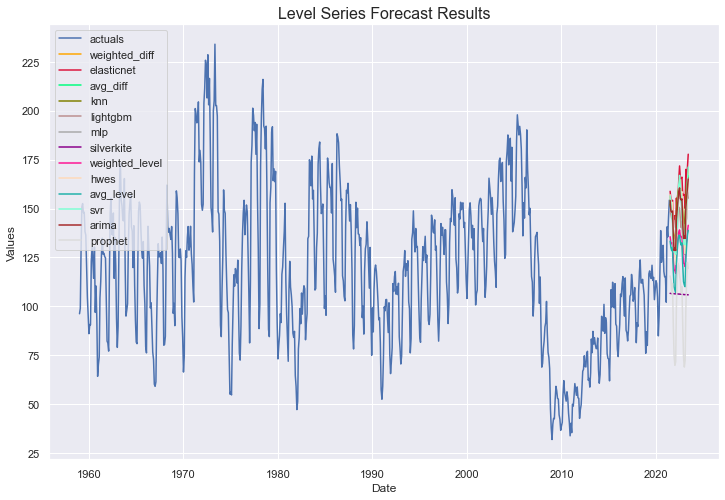

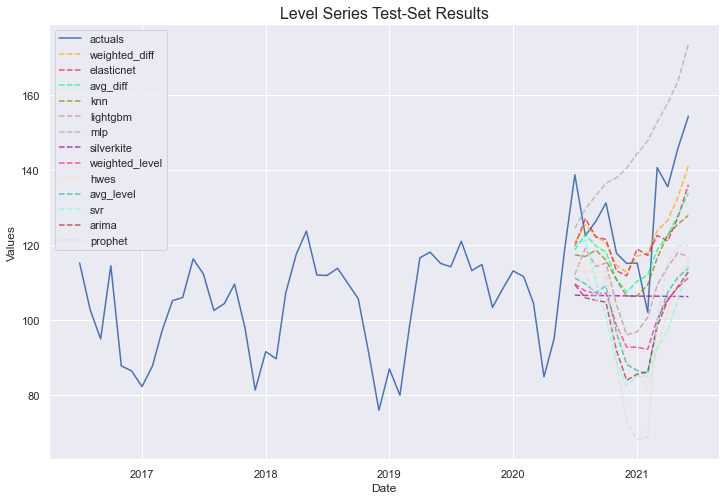

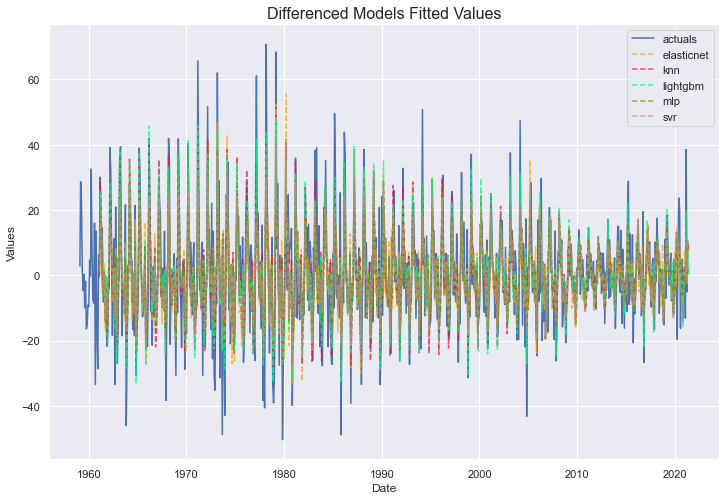

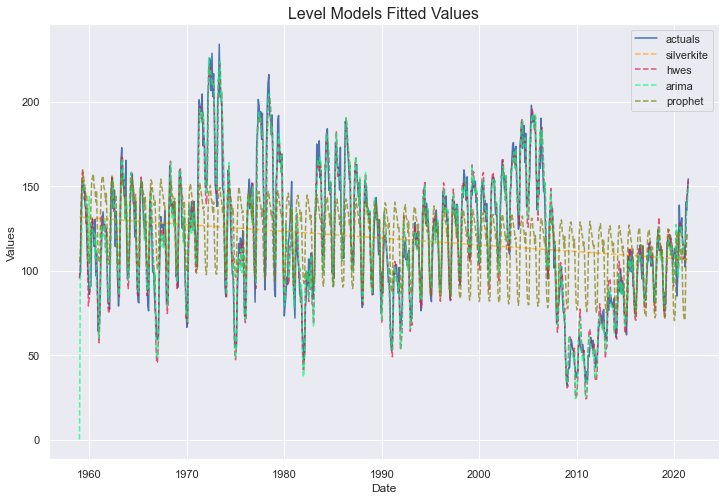

In [2]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster

models = ('knn','svr','lightgbm','mlp','elasticnet')
level_models = ('arima','hwes','prophet','silverkite')
df = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index) # to initialize, specify y and current_dates (must be arrays of the same length)

f.set_test_length(12) # specify a test length for your models--it's a good idea to keep this the same for all forecasts
f.generate_future_dates(24) # this will create future dates that are on the same interval as the current dates and it will also set the forecast length
f.add_ar_terms(4) # add AR terms before differencing
f.add_AR_terms((2,12)) # seasonal AR terms
f.diff() # differences the y term and all ar terms to make a series stationary (also supports 2-level integration)
f.add_seasonal_regressors('month',raw=False,sincos=True) # uses pandas attributes: raw=True creates integers (default), sincos=True creates wave functions (not default), dummy=True creates dummy vars (not default)
f.add_seasonal_regressors('year')
f.add_covid19_regressor() # dates are flexible, default is from when disney world closed to when US CDC lifted mask recommendations
f.add_time_trend()
f.add_combo_regressors('t','COVID19') # multiplies regressors together
f.set_validation_length(6) # length, different than test_length, to tune the hyperparameters 

# automatically tune and forecast with a series of models
f.tune_test_forecast(models,feature_importance=True,summary_stats=True) # by default, tuning is not dynamic but testing is

# combine models and run manually specified models of other varieties
f.set_estimator('combo')
f.manual_forecast(how='simple',models=models,determine_best_by='ValidationMetricValue',call_me='avg_diff') # simple average of top_3 models based on performance in validation
f.manual_forecast(how='weighted',models=models,determine_best_by='ValidationMetricValue',call_me='weighted_diff') # weighted average of all models based on metric specified in determine_best_by (default is the validation metric)

# undifference results to bring back orginal series
f.undiff()
f.tune_test_forecast(level_models,feature_importance=True,summary_stats=True) # by default, tuning is not dynamic but testing is

# combine models and run manually specified models of other varieties
f.set_estimator('combo')
f.manual_forecast(how='simple',models=level_models,determine_best_by='ValidationMetricValue',call_me='avg_level') # simple average of top_3 models based on performance in validation
f.manual_forecast(how='weighted',models=level_models,determine_best_by='ValidationMetricValue',call_me='weighted_level')

# plot results
matplotlib.use('QT5Agg')
sns.set(rc={'figure.figsize':(12,8)})
f.plot(models='all',order_by='LevelTestSetMAPE',print_attr=['LevelTestSetRMSE','LevelTestSetR2','LevelTestSetMAPE','HyperParams','Xvars','models']) # will automatically plot levels for everything
plt.title('Level Series Forecast Results',size=16)
plt.show()
f.plot_test_set(models='all',order_by='LevelTestSetMAPE',include_train=60) # will automatically plot levels for everything
plt.title('Level Series Test-Set Results',size=16)
plt.show()
f.plot_fitted(models=models,order_by='LevelTestSetMAPE') # cannot plot fitted values of all models when levels were different during forecasting
plt.title('Differenced Models Fitted Values',size=16)
plt.show()
f.plot_fitted(models=level_models,order_by='LevelTestSetMAPE')
plt.title('Level Models Fitted Values',size=16)
plt.show()

# export key results
f.export(['model_summaries','lvl_fcsts'],to_excel=True,determine_best_by='LevelTestSetMAPE',excel_name='housing_different_levels_results.xlsx') # export interesting model metrics and forecasts (both level and non-level)
f.all_feature_info_to_excel(excel_name='housing_different_levels_feature_info.xlsx')